In [ ]:
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
import numba


In [341]:
default_pars = {'V_th': 0.0279, 'V_reset': -0.0279, 'tau_m': 5.0,
                'g_L': 1.0, 'V_init': 0, 'E_L': 0.0, 'tref': 2.0,
                'T': 10000.0, 'dt': 0.1, 'tau_ou' : 3., 'range_t': np.arange(2000),'seed':0}
default_pars['range_t'] = np.arange(int(default_pars['T']/default_pars['dt']))


In [62]:
# Definition of the Ornstein-Uhlenbeck input function
def my_OU(pars, mu, sig, myseed=False):
  """
  Function that produces Ornstein-Uhlenbeck input

  Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

  Returns:
    I_ou       : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
    np.random.seed(seed=myseed)
  else:
    np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt-1):
    I_ou[it+1] = I_ou[it] + (dt / tau_ou) * (mu - I_ou[it]) + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1]

  return I_ou



In [67]:
# Definition of LIF
numba.jit(nopython=False)
def run_LIF(pars,Iinj, stop=False):
    """
    Function to simulate the Leaky Integrate-and-Fire (LIF) neuron model.

    Args:
        pars: Parameter dictionary
        Iinj: Input current

    Returns:
        v: Membrane potential
        spikes: Spike times
        I: Input current (same as input)
    """
    
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, E_L = pars['V_init'], pars['E_L']
    dt, range_t = pars['dt'], pars['range_t']
    T = pars['T']
    seed = pars['seed']
    Lt = range_t.size
    tref = pars['tref']
    v = np.zeros(Lt)
    v[0] = V_init
    rec_spikes = []
    tr = 0.

    for it in range(Lt - 1):
        if tr > 0:
            v[it] = V_reset
            tr = tr - 1

        elif v[it] >= V_th:
            rec_spikes.append(it)
            v[it] = V_reset
            tr = tref / dt

        dv = (-(v[it] - E_L) + Iinj[it] / g_L) * (dt / tau_m)
        v[it + 1] = v[it] + dv
        rec_spikes_ = np.array(rec_spikes) * dt

    return v, rec_spikes_, Iinj


<ipython-input-67-a502faf7a5fb>:2: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba.jit(nopython=False)


In [232]:
# Definition of Autocorrelation
numba.jit(nopython=False)

def auto_corr(plot_taus,sigma,t_s):

    """
    Function to calculate autocorrelation.

    Args:
        plot_taus: Time lags for autocorrelation
        sigma: Width of the Gaussian kernel
        t_s: Spike times data for multiple trials

    Returns:
        auto_corr: Autocorrelation values
    """
    Ntr = np.shape(t_s)[0]
    print(Ntr)
    # auto_corr = np.zeros((len(plot_taus),1))
    auto_corr = []
    for k in range(Ntr):
        auto_corr_temp = []
        ST1= t_s[k]
        N = len(ST1)

        s1 = np.repeat(np.expand_dims(ST1.T,axis=0).T,N,axis=1)
        s2 = np.repeat(np.expand_dims(ST1,axis=1).T,N,axis=0)
        for i in range(len(plot_taus)):
            tau = plot_taus[i]
            cons_a = np.exp(-((s1-s2+tau)**2)/(2*(sigma**2)))
            cons_b = np.exp(-(tau)**2/(2*(sigma**2)))
            auto_corr_temp.append((np.sum(cons_a)-N*cons_b)/(np.sqrt(2*np.pi)*sigma))
        auto_corr.append(auto_corr_temp)
    auto_corr=np.mean(auto_corr,axis=0)
    return np.expand_dims(auto_corr,axis=1)

<ipython-input-232-f2e723f69422>:2: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba.jit(nopython=False)


In [385]:
# Definition of cross-correlation
numba.jit(nopython=True)

def cross_corr(plot_taus,sigma,t_s):
    
    Ntr =np.shape(t_s)[1]
    cross_corr = np.zeros((len(plot_taus),1))
    t_s1 = t_s[0]
    t_s2 = t_s[0][1:]
    for k in range(Ntr-1):
        ST1 = t_s1[k]
        ST2 = t_s2[k]
        l1 = len(ST1)
        l2 = len(ST2)
        sig1 = np.expand_dims(ST1,axis=0)
        sig2 = np.expand_dims(ST2,axis=0)
        s1 = np.repeat(sig1.T,l2,axis=1)
        s2 = np.repeat(sig2,l1,axis=0)

        for i in range(len(plot_taus)):
            tau = plot_taus[i]
            cons = np.exp(-(s1-s2+tau)**2/(2*sigma**2))
            cross_corr[i] +=np.sum(cons)/(np.sqrt(2*np.pi)*sigma)

        print(np.shape(cross_corr))
    cross_corr=cross_corr/(Ntr-1)
    return cross_corr




In [344]:
Vth_values = [0.0, 0.03, 0.035]  
spikes_thrs_u = []
spikes_thrs_r = []
default_pars['V_th'] = Vth_values[0]
# default_pars['dt'] = 0.1
spikes_t_s_r = []
spikes_t_s_u = []
N_stim=10
for i in range(N_stim):
    SNR = 0.8
    st = my_OU(default_pars, 0,0.1, myseed=i)
    nt = my_OU(default_pars, 0,0.1, )
    Iinj = SNR * st + np.sqrt(1 - SNR) * nt
    default_pars['seed'] = 1
    v, spikes, I = run_LIF(default_pars,Iinj)
    spikes_t_s_u.append(spikes)
    st = my_OU(default_pars, 0,0.1, myseed=True)
    # nt = my_OU(default_pars, 0,0.1, )
    Iinj = SNR * st + np.sqrt(1 - SNR) * nt
    default_pars['seed'] = 1
    v, spikes, I = run_LIF(default_pars,Iinj)
    spikes_t_s_r.append(spikes)
spikes_thrs_u.append(spikes_t_s_u)
spikes_thrs_r.append(spikes_t_s_r)


In [347]:
spike_times = np.int32(spikes/default_pars['dt'])

b_spikes = np.zeros_like(v)*np.nan
b_spikes[spike_times] =1


1071.0

In [416]:
np.shape(spikes_thrs_r[0][1])

(1085,)

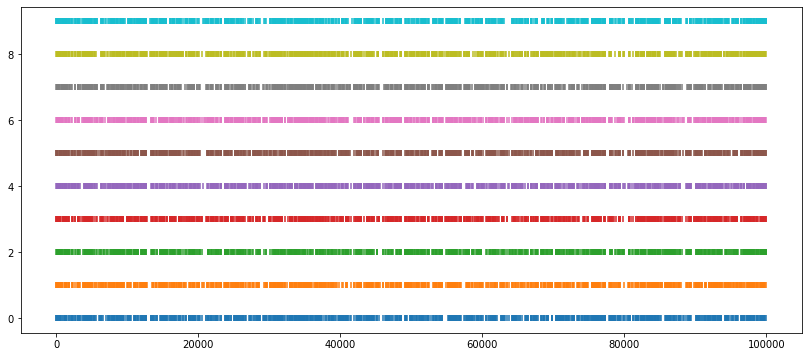

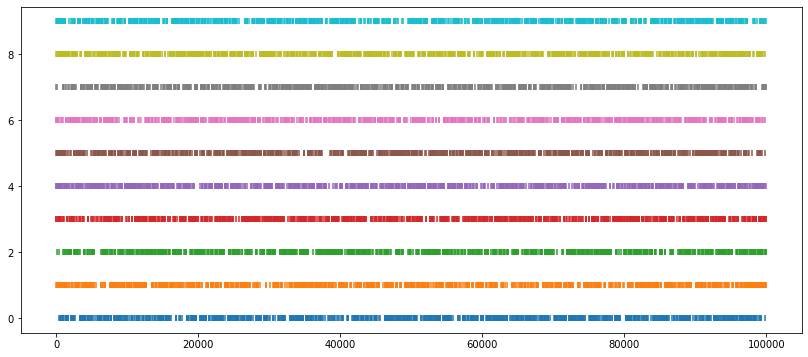

In [417]:
spikes_t = spikes_thrs_r
# print(np.shape(spikes_t[i][0][0]))
fig,ax = plt.subplots(figsize= [14,6])
for i in range(10):
    b_spikes = np.zeros((np.int32(10000/0.1)))*np.nan
    s_times = np.int32(spikes_t[0][i]/0.1)
    b_spikes[s_times]=1
    plt.scatter(np.arange(np.int32(10000/0.1)),b_spikes*i,marker='|')
plt.show()

spikes_t = spikes_thrs_u
# print(np.shape(spikes_t[i][0][0]))
fig,ax = plt.subplots(figsize= [14,6])
for i in range(10):
    b_spikes = np.zeros((np.int32(10000/0.1)))*np.nan
    s_times = np.int32(spikes_t[0][i]/0.1)
    b_spikes[s_times]=1
    plt.scatter(np.arange(np.int32(10000/0.1)),b_spikes*i,marker='|')
plt.show()

In [309]:
temp = np.expand_dims(np.array(spikes_t_s_r),axis=1).T

t_s1 = temp[0]
t_s2 = temp[0][1:]
np.shape(t_s2)

<ipython-input-309-0b0d740ab104>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp = np.expand_dims(np.array(spikes_t_s_r),axis=1).T


(9,)

In [348]:
num_tau_min = -100  #% (ms)
num_tau_max =  100  #% (ms)
num_dtau    =  0.1  #% (ms)
                  
num_taus         = np.arange(num_tau_min,
                     num_tau_max+num_dtau,
                     num_dtau)

sigma            = 0.01
autocor_num_u    = auto_corr(num_taus, sigma, np.array(spikes_t_s_u))  # what is sigma?
crosscorr_num_r  = cross_corr(num_taus, sigma, np.expand_dims(np.array(spikes_t_s_r),axis=1).T)

<ipython-input-348-7195974402de>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  autocor_num_u = auto_corr(num_taus,sigma,np.array(spikes_t_s_u))  # what is sigma?


10
(1057,)
(1065,)
(1027,)
(1065,)
(1025,)
(1067,)
(969,)
(1007,)
(1046,)
(1013,)


<ipython-input-348-7195974402de>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  crosscorr_num_r  = cross_corr(num_taus, sigma, np.expand_dims(np.array(spikes_t_s_r),axis=1).T)


(2001, 1)
(2001, 1)
(2001, 1)
(2001, 1)
(2001, 1)
(2001, 1)
(2001, 1)
(2001, 1)
(2001, 1)


In [333]:
np.shape(np.array(autocor_num_u))

(2001, 1)

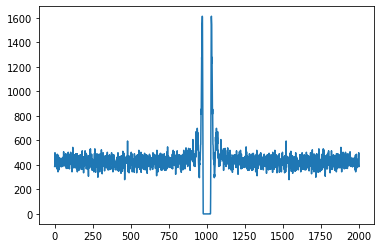

In [350]:

plt.plot(autocor_num_u)

In [391]:
from scipy.fft import fft, fftfreq,rfft


def My_DFT_custom_freqs(t,x,freqs):
    # %MY_DFT Gives the discrete fouriertransform for an input of a time vector t
    # % and the function x that will be fouriertransformed. 
    # %   Also we could introduce a custom freqs vector in the future to
    # %   customize the frequency resolution.
    print(x.shape)
    f_coefs = np.zeros((1,len(freqs)))
    
    
    T_seq = np.max(t) - np.min(t)
    for k in range(f_coefs.shape[1]):
        # print(np.exp(-1j*2*np.pi*freqs[k]*t[:-1]))
        f_coefs[0,k] = np.real(np.mean(x[0,:-1]*(np.exp(-1j*2*np.pi*freqs[k]*t[:-1]))))
        # print((np.exp(-1j*2*np.pi*freqs[k]*t[:-1])))
    
    return f_coefs

In [392]:
freq_max = 500 # Max frequency to evaluate (Hz)
delta_f = 1
# % Assigning vectors
freqs = np.arange(0,freq_max+delta_f, delta_f) #;
Nf = len(freqs) #; % number of frequencies
num_delta_f = 1/(num_tau_max-num_tau_min)*1000
num_freqs   = np.arange(0,(1/num_dtau*1000/2)+num_delta_f, num_delta_f)/1000
steps = 10000
dt = 0.1
T_seq_korrigiert = steps*dt
N = 1
Ntr = 10
FiR_u = np.zeros((1,Ntr))
FiR_r = np.zeros((1,Ntr))
for j  in range(Ntr):
   FiR_u[0,j] = len(spikes_t_s_u[j])/T_seq_korrigiert
   FiR_r[0,j] = len(spikes_t_s_r[j])/T_seq_korrigiert
FiR_u_mean = np.mean(FiR_u)
FiR_r_mean = np.mean(FiR_r)
# % Fouriertranformations
Off_Fac_num_u = 1/(num_tau_max-num_tau_min)*FiR_u_mean*T_seq_korrigiert
# %  Numeric functions
auto_four_u_temp   = np.real(My_DFT_custom_freqs(num_taus, autocor_num_u.T, num_freqs))
auto_four_u  = np.real(auto_four_u_temp)
cross_four_r_temp  = np.real(My_DFT_custom_freqs(num_taus, crosscorr_num_r.T, num_freqs))
cross_four_r = np.real(cross_four_r_temp)
Info_pn_cor2  = -1/2*np.log2(1-(cross_four_r/(auto_four_u+Off_Fac_num_u))) # % Hier repeaats

(1, 2001)
(1, 2001)


<ipython-input-392-70ad5c27ad0f>:27: RuntimeWarning: invalid value encountered in log2
  Info_pn_cor2  = -1/2*np.log2(1-(cross_four_r/(auto_four_u+Off_Fac_num_u))) # % Hier repeaats


In [409]:
cross_four_r

array([[501.51920608,  24.94664783,  19.2368999 , ...,  -0.69577661,
          1.07485041,   0.93529801]])

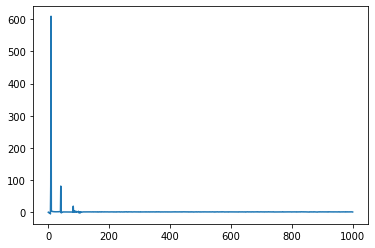

In [407]:
# plt.plot(cross_four_r.T)
plt.plot((1-cross_four_r/(auto_four_u+Off_Fac_num_u)).T)
# plt.plot(Info_pn_cor2.T)

In [364]:
# # Definition of Information content
# def return_info(spikes_t_s_u,spikes_t_s_r,autocor_num_u,crosscorr_num_r):

#     """
#     Function to compute the mutual information between spike trains.

#     Args:
#         spikes_t_s_u: Spike times for stimulus condition
#         spikes_t_s_r: Spike times for response condition

#     Returns:
#         Info_pn_cor2: Mutual information values
    
#     """
#     freq_max = 500 # Max frequency to evaluate (Hz)
#     delta_f = 1 

#    # Assigning vectors
#     freqs = np.arange(0,freq_max+delta_f, delta_f) #;

#    #number of frequencies
#     Nf = len(freqs)
    
#     num_delta_f = 1/(num_tau_max-num_tau_min)*1000
#     num_freqs   = np.arange(0,(1/num_dtau*1000/2)+num_delta_f, num_delta_f)/1000
#     steps = 10000
#     dt = 0.1
#     T_seq_korrigiert = steps*dt
#     N = 1
#     Ntr = 3
#     FiR_u = np.zeros((1,Ntr))
#     FiR_r = np.zeros((1,Ntr))


#     for j  in range(Ntr):
#       FiR_u[0,j] = len(spikes_t_s_u.T[j])/T_seq_korrigiert
#       FiR_r[0,j] = len(spikes_t_s_r.T[j])/T_seq_korrigiert

#     FiR_u_mean = np.mean(FiR_u)
#     FiR_r_mean = np.mean(FiR_r)
#    # % Fouriertranformations

#     Off_Fac_num_u = 1/(num_tau_max-num_tau_min)*FiR_u_mean*T_seq_korrigiert

#     # %  Numeric functions
#     auto_four_u_temp   = np.real(My_DFT_custom_freqs(num_taus, autocor_num_u.T, num_freqs))
#     auto_four_u  = np.real(auto_four_u_temp)

#     cross_four_r_temp  = np.real(My_DFT_custom_freqs(num_taus, crosscorr_num_r.T, num_freqs))
#     cross_four_r = np.real(cross_four_r_temp)

#     Info_pn_cor2  = -1/2*np.log2(1-(cross_four_r/(auto_four_u+Off_Fac_num_u))) 


#     Total_info_rate = np.sum(Info_pn_cor2)
    
#     return Info_pn_cor2


In [365]:
info =  return_info(np.array(test_spike_t_s_u)[:3].T, np.array(test_spike_t_s_r)[:3].T, np.array(autocor_num_u),np.array(crosscorr_num_r))

(1, 2001)
(1, 2001)


<ipython-input-134-5e9271b751c2>:52: RuntimeWarning: invalid value encountered in log2
  Info_pn_cor2  = -1/2*np.log2(1-(cross_four_r/(auto_four_u+Off_Fac_num_u)))


In [366]:
def calculate_mutual_information(Vth_values, other_parameters):
    """
    Function to calculate mutual information for varying threshold values.

    Args:
        Vth_values: List of threshold values to vary
        other_parameters: Dictionary of other parameters for simulation

    Returns:
        mutual_info_results: List of mutual information values for each Vth value
    """
    mutual_info_results = []
    Vth_values = [0.025, 0.03, 0.035]  
    spikes_thrs_u = []
    spikes_thrs_r = []
    for Vth in Vth_values:
        default_pars['V_th'] = Vth
        spikes_t_s_r = []
        spikes_t_s_u = []
        for i in range(N_stim):
            SNR = 0.6
            st = my_OU(default_pars, 0,0.1, myseed=i)
            nt = my_OU(default_pars, 0,0.1, )
            Iinj = SNR * st + np.sqrt(1 - SNR) * nt
            default_pars['seed'] = 1
            v, spikes, I = run_LIF(default_pars,Iinj)
            spikes_t_s_u.append(spikes)


            st = my_OU(default_pars, 0,0.1, myseed=0)
            nt = my_OU(default_pars, 0,0.1, )
            Iinj = SNR * st + np.sqrt(1 - SNR) * nt
            default_pars['seed'] = 1
            v, spikes, I = run_LIF(default_pars,Iinj)
            spikes_t_s_r.append(spikes)
        spikes_thrs_u.append(spikes_t_s_u)
        spikes_thrs_r.append(spikes_t_s_r)
    info = return_info(spikes_t_s_u, spikes_t_s_r)
    Info_pn_cor2  = -1/2*np.log2(1-(cross_four_r/(auto_four_u+Off_Fac_num_u))) 
    Info_pn_cor2.append(info)
    Total_info_rate = np.sum(Info_pn_cor2)
    return Info_pn_cor2

# # Plotting information content vs Vth
# plt.plot(Vth_values, info_content)
# plt.xlabel('Vth values')
# plt.ylabel('Information Content')
# plt.title('Effect of Vth on Information Content')
# plt.show()
# # fig, ax = plt.subplots(figsize=[8, 4])
# # ax.legend()
# # ax.set_xlabel('Time (ms)')
# # ax.set_ylabel('Membrane Potential')
# # plt.show()



In [367]:
#Plot for spike crosscorrelation
# plt.plot(num_taus,crosscorr_num_r)

In [368]:
# Plot for the spike autocorrelation
# plt.plot(num_taus,autocor_num_u)

In [369]:
# list_of_infos = []
# for each_thr in thrs:
#     spikes_u
#     spikes_r

#     autcorr(spikes_u)
#     corss_corr(spiokes_r)
#     list_of_infos.append(info_metric(auto,corss))

In [370]:
print("Information Rate per frequency (Info_pn_cor2):")
print(Info_pn_cor2)

print("Total Information Rate (Total_info_rate):")
print(Total_info_rate)

plt.plot(num_freqs*100,Info_pn_cor2[0])
plt.xlabel("Frequenzy (Hz)")
plt.ylabel("Information rate (bits/(Hz*s))")
plt.title("Neural Information Content")
plt.text(250, 1.5, f'Total Info Rate: {Total_info_rate:.2f} bits/sec', color='r')

Information Rate per frequency (Info_pn_cor2):
[[nan nan nan ... nan nan nan]]
Total Information Rate (Total_info_rate):


NameError: name 'Total_info_rate' is not defined